# Classificação - Português

Este notebook realiza a modelagem preditiva da aprovação estudantil na disciplina de **Português**, com base em atributos contextuais e de desempenho. A análise inclui:
- Preparação dos dados
- Avaliação de classificadores binários
- Comparação com e sem balanceamento
- Otimização de hiperparâmetros

**Base:** Student Performance Dataset (UCI)  
**Target:** variável `aprovacao` (0 = Reprovado, 1 = Aprovado)

# 1. Importação e setup

In [1]:
# Permite importar módulos .py que estão na raiz do repositório 

import sys, pathlib
ROOT = pathlib.Path().resolve().parents[1]  # sobe de EDA/ para a raiz
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))


In [2]:
#Importação dos Módulos e Funções Desenvolvidos

from pre_modelagem import *
from modelagem import *
# Importação de bibliotecas padrão
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

materia = 'portugues'
df_raw = importar_base(materia)
df_modelo = preparar_dados(df_raw, scaling=True, classificacao=True)

X = df_modelo.drop(columns='aprovacao').values
y = df_modelo['aprovacao'].values


# Configurações do Pandas para exibir todas as linhas e colunas no DataFrame 
# para inspeção detalhada dos dados no Jupyter Notebook

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings

# Ignora todos os warnings
warnings.filterwarnings('ignore')

1    549
0    100
Name: aprovacao, dtype: int64
1    549
0    100
Name: aprovacao, dtype: int64


# Avaliação dos modelos
## Subseção 2.1 - Modelos considerados
- Regressão Logística
- Árvore de Decisão
- Random Forest
- SVM (com probabilidade)
- Gradient Boosting (substituindo AdaBoost)

Avaliamos os modelos com **validação cruzada** e também com **balanceamento SMOTE-Tomek** nos dados de treino.

In [3]:
# === Classificadores base ===
classificadores = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

# === Dicionário de hiperparâmetros para otimização ===
param_grid_dicts = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10],
        "solver": ["lbfgs", "liblinear"],
        "penalty": ["l2"]
    },
    "DecisionTree": {
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10],
        "criterion": ["gini", "entropy"]
    },
    "RandomForest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, None],
        "max_features": ["sqrt", "log2"]
    },
    "GradientBoosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.3],
        "max_depth": [2, 3, 5]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf"],
        "gamma": ["scale", "auto"]
    }
}



# 3.  Comparação de desempenho
## 3.1. Visualização dos rankings por métrica
Inclui: Acurácia, F1-Score, AUC-ROC e outras métricas para os dois cenários:
- Dados originais
- Dados balanceados

In [4]:
# === Avaliação SEM balanceamento ===
df_resultados, df_cv, best_params_df = avaliar_classificadores_binarios_otimizados(
    classificadores=classificadores,
    X=X,
    y=y,
    materia="portugues",  # ou "matematica"
    usar_balanceamento=False,
    param_spaces=param_grid_dicts
)

# === Avaliação COM balanceamento ===
df_resultados_bal, df_cv_bal, best_params_df_bal = avaliar_classificadores_binarios_otimizados(
    classificadores=classificadores,
    X=X,
    y=y,
    materia="portugues",  # ou "matematica"
    usar_balanceamento=True,
    param_spaces= param_grid_dicts
)

,Modelo,Acurácia,Precisão(0),Precisão(1),Recall(0),Recall(1),F1 Score (Reprovado),F1 Score (Macro),AUC ROC
0,Logistic Regression Sem Otimizacao,0.815385,0.363636,0.872832,0.266667,0.915152,0.307692,0.600592,0.695152
1,Logistic Regression Com Otimizacao,0.810256,0.347826,0.872093,0.266667,0.909091,0.301887,0.596047,0.694343
2,DecisionTree Sem Otimizacao,0.753846,0.235294,0.863354,0.266667,0.842424,0.250000,0.551380,NaN
3,DecisionTree Com Otimizacao,0.789744,0.358974,0.897436,0.466667,0.848485,0.405797,0.639036,0.687677
4,RandomForest Sem Otimizacao,0.830769,0.384615,0.862637,0.166667,0.951515,0.232558,0.568729,0.751919
5,RandomForest Com Otimizacao,0.825641,0.375000,0.865922,0.200000,0.939394,0.260870,0.581016,0.766869
6,GradientBoosting Sem Otimizacao,0.820513,0.380952,0.873563,0.266667,0.921212,0.313725,0.605240,0.746465
7,GradientBoosting Com Otimizacao,0.815385,0.363636,0.872832,0.266667,0.915152,0.307692,0.600592,0.726667
8,SVM Sem Otimizacao,0.846154,0.500000,0.864865,0.166667,0.969697,0.250000,0.582143,0.749899
9,SVM Com Otimizacao,0.784615,0.269231,0.863905,0.233333,0.884848,0.250000,0.562126,0.755354


,Modelo,Validação Cruzada (AUC ROC),Validação Cruzada (Acurácia),Validação Cruzada (Precisão(0)),Validação Cruzada (Precisão(1)),Validação Cruzada (Recall(0)),Validação Cruzada (Recall(1)),Validação Cruzada (F1 Score (Reprovado)),Validação Cruzada (F1 Score (Macro))
0,Logistic Regression Sem Otimizacao,0.788,0.849,0.503,0.878,0.27,0.954,0.344,0.629
1,Logistic Regression Com Otimizacao,0.778,0.841,0.470,0.878,0.28,0.944,0.348,0.629
2,DecisionTree Sem Otimizacao,0.681,0.814,0.405,0.905,0.49,0.873,0.438,0.663
3,DecisionTree Com Otimizacao,0.750,0.837,0.488,0.896,0.42,0.913,0.444,0.674
4,RandomForest Sem Otimizacao,0.835,0.854,0.666,0.866,0.17,0.978,0.254,0.586
5,RandomForest Com Otimizacao,0.829,0.855,0.602,0.869,0.19,0.976,0.279,0.599
6,GradientBoosting Sem Otimizacao,0.797,0.846,0.537,0.884,0.32,0.942,0.389,0.650
7,GradientBoosting Com Otimizacao,0.790,0.841,0.503,0.891,0.38,0.925,0.424,0.666
8,SVM Sem Otimizacao,0.797,0.857,0.673,0.864,0.15,0.985,0.233,0.577
9,SVM Com Otimizacao,0.791,0.843,0.476,0.882,0.31,0.940,0.371,0.641



--- Comparando Resultados para a Métrica: Recall(0) ---


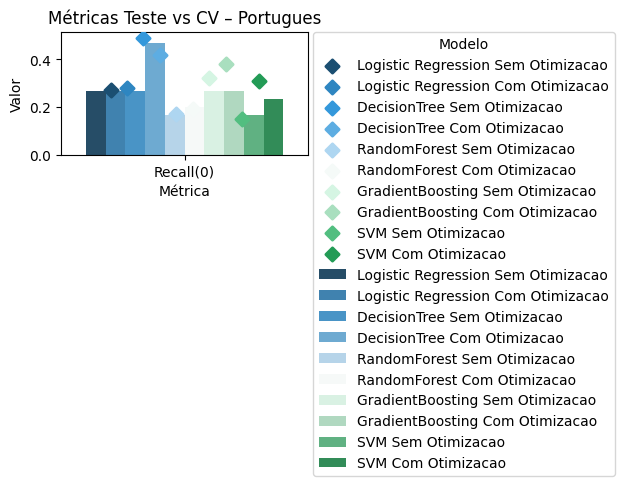


--- Comparando Resultados para a Métrica: F1 Score (Reprovado) ---


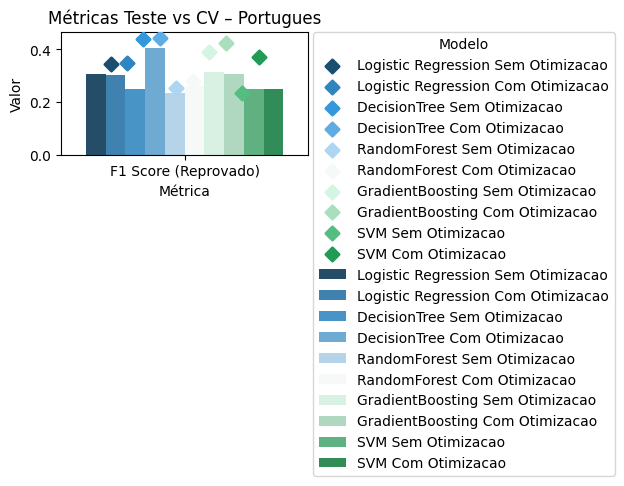


--- Comparando Resultados para a Métrica: F1 Score (Macro) ---


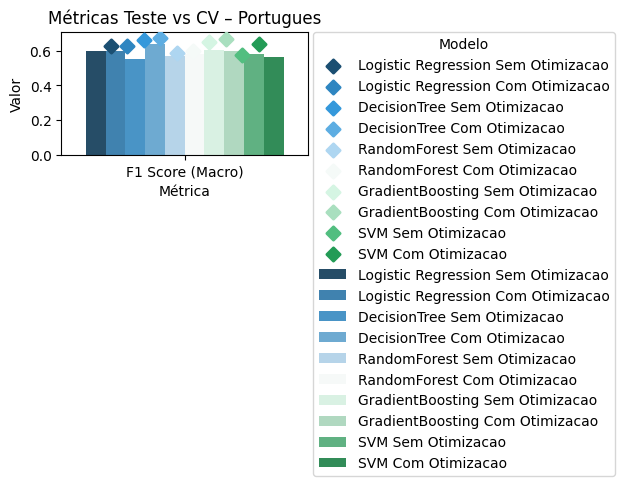


--- Comparando Resultados para a Métrica: AUC ROC ---


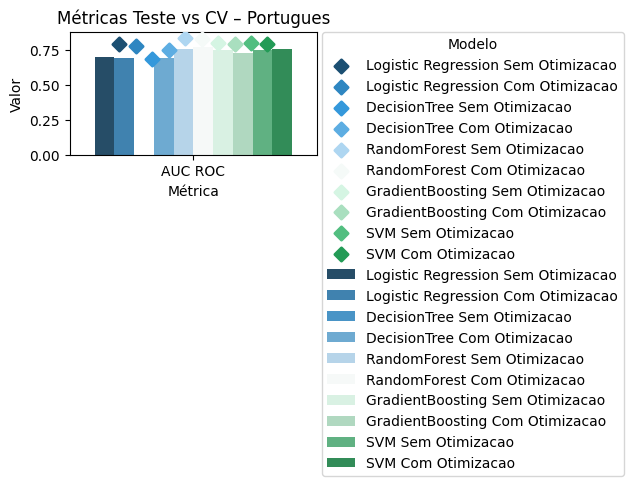

In [5]:
display(df_resultados)

display(df_cv)

verificar_overfitting(df_resultados_bal, df_cv)

metricas_interesse = ['Recall(0)', 'F1 Score (Reprovado)', 'F1 Score (Macro)', 'AUC ROC']


for metric in metricas_interesse:
    if metric:
        print(f"\n--- Comparando Resultados para a Métrica: {metric} ---")
        comparar_resultados_classificacao(
                                            df_test=df_resultados, 
                                            df_cv=df_cv,           
                                            metrics=metric,        
                                            materia=materia  
                                         )     

,Modelo,Acurácia,Precisão(0),Precisão(1),Recall(0),Recall(1),F1 Score (Reprovado),F1 Score (Macro),AUC ROC
0,Logistic Regression Sem Otimizacao,0.717949,0.272727,0.892857,0.500000,0.757576,0.352941,0.586307,0.702222
1,Logistic Regression Com Otimizacao,0.717949,0.272727,0.892857,0.500000,0.757576,0.352941,0.586307,0.702222
2,DecisionTree Sem Otimizacao,0.758974,0.282051,0.878205,0.366667,0.830303,0.318841,0.586212,NaN
3,DecisionTree Com Otimizacao,0.800000,0.363636,0.888889,0.400000,0.872727,0.380952,0.630843,NaN
4,RandomForest Sem Otimizacao,0.800000,0.304348,0.866279,0.233333,0.903030,0.264151,0.574212,0.744343
5,RandomForest Com Otimizacao,0.805128,0.300000,0.862857,0.200000,0.915152,0.240000,0.564118,0.739798
6,GradientBoosting Sem Otimizacao,0.810256,0.370370,0.880952,0.333333,0.896970,0.350877,0.619883,0.712929
7,GradientBoosting Com Otimizacao,0.800000,0.333333,0.875000,0.300000,0.890909,0.315789,0.599336,0.707879
8,SVM Sem Otimizacao,0.779487,0.290323,0.871951,0.300000,0.866667,0.295082,0.582191,0.712929
9,SVM Com Otimizacao,0.789744,0.296296,0.869048,0.266667,0.884848,0.280702,0.578789,0.715960


,Modelo,Validação Cruzada (AUC ROC),Validação Cruzada (Acurácia),Validação Cruzada (Precisão(0)),Validação Cruzada (Precisão(1)),Validação Cruzada (Recall(0)),Validação Cruzada (Recall(1)),Validação Cruzada (F1 Score (Reprovado)),Validação Cruzada (F1 Score (Macro))
0,Logistic Regression Sem Otimizacao,0.788,0.849,0.503,0.878,0.27,0.954,0.344,0.629
1,Logistic Regression Com Otimizacao,0.788,0.849,0.503,0.878,0.27,0.954,0.344,0.629
2,DecisionTree Sem Otimizacao,0.681,0.814,0.405,0.905,0.49,0.873,0.438,0.663
3,DecisionTree Com Otimizacao,0.667,0.817,0.410,0.899,0.45,0.883,0.422,0.656
4,RandomForest Sem Otimizacao,0.835,0.854,0.666,0.866,0.17,0.978,0.254,0.586
5,RandomForest Com Otimizacao,0.838,0.852,0.555,0.863,0.14,0.982,0.211,0.565
6,GradientBoosting Sem Otimizacao,0.797,0.846,0.537,0.884,0.32,0.942,0.389,0.650
7,GradientBoosting Com Otimizacao,0.777,0.832,0.461,0.884,0.33,0.924,0.372,0.637
8,SVM Sem Otimizacao,0.797,0.857,0.673,0.864,0.15,0.985,0.233,0.577
9,SVM Com Otimizacao,0.775,0.844,0.501,0.882,0.31,0.942,0.379,0.645



--- Comparando Resultados para a Métrica: Recall(0) ---


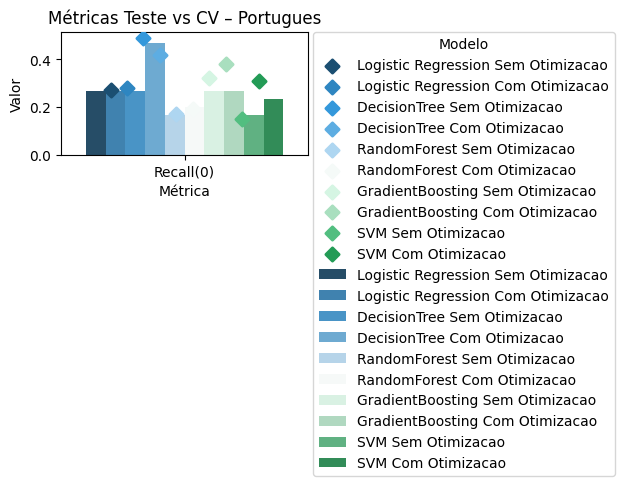


--- Comparando Resultados para a Métrica: F1 Score (Reprovado) ---


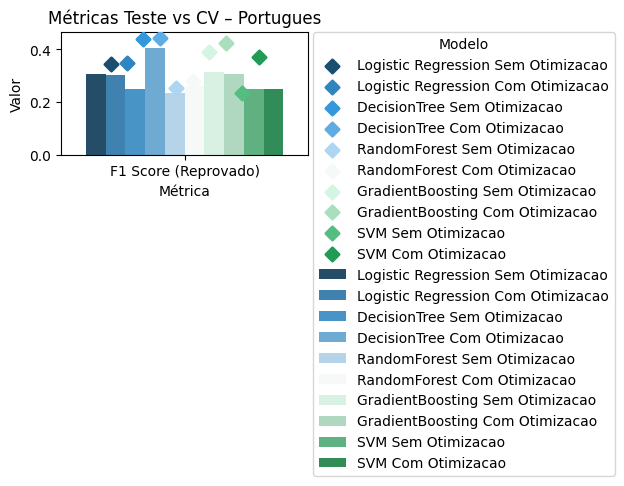


--- Comparando Resultados para a Métrica: F1 Score (Macro) ---


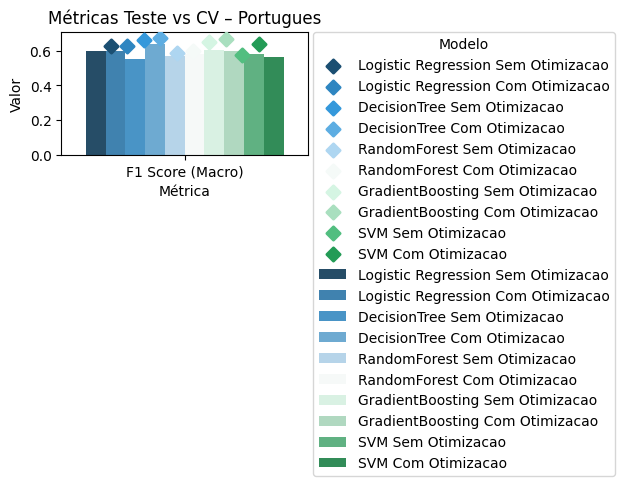


--- Comparando Resultados para a Métrica: AUC ROC ---


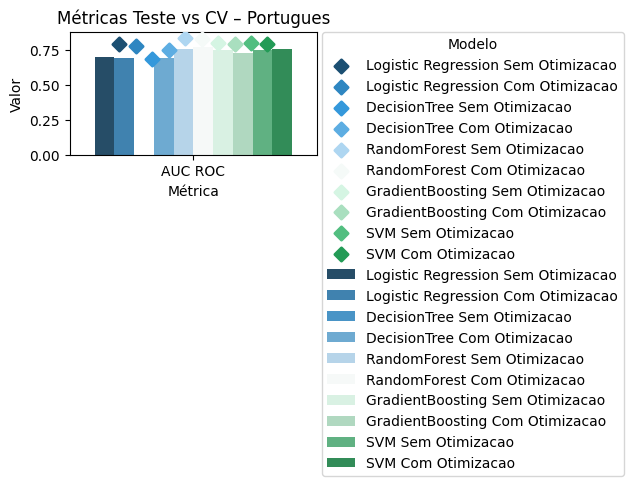

In [6]:
display(df_resultados_bal)

display(df_cv_bal)

verificar_overfitting(df_resultados_bal, df_cv_bal)


metricas_interesse = ['Recall(0)', 'F1 Score (Reprovado)', 'F1 Score (Macro)', 'AUC ROC']


for metric in metricas_interesse:
    if metric:
        print(f"\n--- Comparando Resultados para a Métrica: {metric} ---")
        comparar_resultados_classificacao(
                                            df_test=df_resultados, 
                                            df_cv=df_cv,           
                                            metrics=[metric],        
                                            materia=materia  
                                         )     

# 4 . Modelagem 1: Seleção Baseada em Critérios Estatísticos e Relevância Direta

**Objetivos:**
- Foco na escolha de atributos que demonstram uma relação estatisticamente significativa com a variável alvo ('aprovacao')
- multicolinearidade critério de alta relevância.

In [7]:
#Base pré-processada com scaling True:
df_ts = importar_base(materia=materia)
df_ts = preparar_dados(df_ts,classificacao=True)



1    549
0    100
Name: aprovacao, dtype: int64
1    549
0    100
Name: aprovacao, dtype: int64


In [8]:
#Base pré-processada com scaling True:
df_fs = importar_base(materia=materia)
df_fs = preparar_dados(df_fs,classificacao=True,scaling=True)

1    549
0    100
Name: aprovacao, dtype: int64
1    549
0    100
Name: aprovacao, dtype: int64


## 4.1 **METODOLOGIA DA SELEÇÃO DOS ATRIBUTOS**

### Seleção Categórica (Qui-Quadrado): Utilizar o teste Qui-Quadrado χ 

- avaliar a associação entre cada variável categórica (nominal ou binária, após one-hot encoding) e a variável 'aprovacao'. 
Selecionar apenas as variáveis com valor-p < 0.05 (ou um limiar similar).


In [9]:
variaveis_dummies_chi2 = [
    'escola_Mousinho da Silveira',
    'motivo_escolha_escola_Reputação da escola',
    'intencao_superior',
    'profissao_mae_Professor(a)',
    'motivo_escolha_escola_Outro motivo'
]


### Seleção Quantitativa/Ordinal (Correlação/Significância):

- Calcular a correlação (ex: Spearman) entre as variáveis quantitativas/ordinais e a variável 'aprovacao'. 
Selecionar aquelas com correlação significativa (considerando um limiar de valor absoluto e/ou valor-p).


In [10]:
variaveis_ordinais_relevantes = [
    'tempo_estudo', 'reprovacoes', 'tempo_livre',
    'frequencia_saidas', 'alcool_fim_semana', 'saude', 'faltas'
]



### Tratamento de Multicolinearidade (VIF/Correlação):
- variáveis com alta correlação (>0.6) e VIF > 5 identificados: (escolaridade_mae/pai, alcool_dias_uteis/fim_semana).
- Foram escolhidos para serem removidos: escolaridade_pai e alcool_fim_semana


In [11]:

variaveis_alta_colineariedade = [
            'escolaridade_mae',
            #'escolaridade_pai',
            'alcool_fim_semana',
            #'alcool_dias_uteis',
            #'profissao_pai_Outra profissão',
            #'profissao_pai_Serviços'
        ]


In [12]:
selecao = variaveis_ordinais_relevantes + variaveis_dummies_chi2+variaveis_alta_colineariedade

In [13]:
df_corr_dummies = df_fs[selecao].corr()
df_corr_dummies.T


,tempo_estudo,reprovacoes,tempo_livre,frequencia_saidas,alcool_fim_semana,saude,faltas,escola_Mousinho da Silveira,motivo_escolha_escola_Reputação da escola,intencao_superior,profissao_mae_Professor(a),motivo_escolha_escola_Outro motivo,escolaridade_mae,alcool_fim_semana
tempo_estudo,1.000000,-0.147441,-0.068829,-0.075442,-0.214925,-0.056433,-0.118389,-0.137857,0.179023,0.188256,0.035469,-0.088833,0.097006,-0.214925
reprovacoes,-0.147441,1.000000,0.108995,0.045078,0.082266,0.035588,0.122779,0.113788,-0.111185,-0.309400,-0.123945,0.000204,-0.172210,0.082266
tempo_livre,-0.068829,0.108995,1.000000,0.346352,0.120244,0.084526,-0.018716,0.034666,-0.009839,-0.102618,0.060821,-0.032606,-0.019686,0.120244
frequencia_saidas,-0.075442,0.045078,0.346352,1.000000,0.388680,-0.015741,0.085374,0.044632,-0.004559,-0.069105,-0.055594,0.002870,0.009536,0.388680
alcool_fim_semana,-0.214925,0.082266,0.120244,0.388680,1.000000,0.114988,0.156373,0.014169,-0.026365,-0.084327,0.018384,0.060435,-0.019766,1.000000
saude,-0.056433,0.035588,0.084526,-0.015741,0.114988,1.000000,-0.030235,-0.058599,-0.112359,0.017290,0.031889,0.008124,0.004614,0.114988
faltas,-0.118389,0.122779,-0.018716,0.085374,0.156373,-0.030235,1.000000,-0.163933,0.017392,-0.129891,-0.041773,-0.067165,-0.008577,0.156373
escola_Mousinho da Silveira,-0.137857,0.113788,0.034666,0.044632,0.014169,-0.058599,-0.163933,1.000000,-0.162282,-0.136112,-0.103729,0.205220,-0.254787,0.014169
motivo_escolha_escola_Reputação da escola,0.179023,-0.111185,-0.009839,-0.004559,-0.026365,-0.112359,0.017392,-0.162282,1.000000,0.098936,-0.022069,-0.187789,0.132502,-0.026365
intencao_superior,0.188256,-0.309400,-0.102618,-0.069105,-0.084327,0.017290,-0.129891,-0.136112,0.098936,1.000000,0.105923,-0.053244,0.213896,-0.084327


In [14]:
selecao.remove('frequencia_saidas')

In [15]:
variaveis_final = sorted(selecao)
X = df_fs[variaveis_final]
y = df_fs['aprovacao']

In [16]:
# === Avaliação SEM balanceamento ===
df_resultados, df_cv, best_params_df = avaliar_classificadores_binarios_otimizados(
    classificadores=classificadores,
    X=X,
    y=y,
    materia="portugues",  # ou "matematica"
    usar_balanceamento=False,
    param_spaces=param_grid_dicts
)

# === Avaliação COM balanceamento ===
df_resultados_bal, df_cv_bal, best_params_df_bal = avaliar_classificadores_binarios_otimizados(
    classificadores=classificadores,
    X=X,
    y=y,
    materia="portugues",  # ou "matematica"
    usar_balanceamento=True,
    param_spaces= param_grid_dicts
)

,Modelo,Acurácia,Precisão(0),Precisão(1),Recall(0),Recall(1),F1 Score (Reprovado),F1 Score (Macro),AUC ROC
0,Logistic Regression Sem Otimizacao,0.789744,0.238095,0.856322,0.166667,0.903030,0.196078,0.537567,0.732323
1,Logistic Regression Com Otimizacao,0.789744,0.238095,0.856322,0.166667,0.903030,0.196078,0.537567,0.732323
2,DecisionTree Sem Otimizacao,0.764103,0.233333,0.860606,0.233333,0.860606,0.233333,0.546970,NaN
3,DecisionTree Com Otimizacao,0.774359,0.294118,0.875776,0.333333,0.854545,0.312500,0.588765,0.606061
4,RandomForest Sem Otimizacao,0.794872,0.250000,0.857143,0.166667,0.909091,0.200000,0.541176,0.701111
5,RandomForest Com Otimizacao,0.794872,0.250000,0.857143,0.166667,0.909091,0.200000,0.541176,0.701111
6,GradientBoosting Sem Otimizacao,0.800000,0.285714,0.862069,0.200000,0.909091,0.235294,0.560125,0.714545
7,GradientBoosting Com Otimizacao,0.825641,0.400000,0.874286,0.266667,0.927273,0.320000,0.610000,0.739697
8,SVM Sem Otimizacao,0.825641,0.333333,0.857923,0.133333,0.951515,0.190476,0.546388,0.709091
9,SVM Com Otimizacao,0.800000,0.263158,0.857955,0.166667,0.915152,0.204082,0.544856,0.754343


,Modelo,Validação Cruzada (AUC ROC),Validação Cruzada (Acurácia),Validação Cruzada (Precisão(0)),Validação Cruzada (Precisão(1)),Validação Cruzada (Recall(0)),Validação Cruzada (Recall(1)),Validação Cruzada (F1 Score (Reprovado)),Validação Cruzada (F1 Score (Macro))
0,Logistic Regression Sem Otimizacao,0.829,0.857,0.586,0.879,0.27,0.964,0.362,0.641
1,Logistic Regression Com Otimizacao,0.829,0.857,0.586,0.879,0.27,0.964,0.362,0.641
2,DecisionTree Sem Otimizacao,0.657,0.800,0.381,0.896,0.45,0.863,0.409,0.644
3,DecisionTree Com Otimizacao,0.702,0.812,0.425,0.896,0.44,0.880,0.427,0.657
4,RandomForest Sem Otimizacao,0.805,0.861,0.623,0.886,0.32,0.960,0.406,0.664
5,RandomForest Com Otimizacao,0.805,0.861,0.623,0.886,0.32,0.960,0.406,0.664
6,GradientBoosting Sem Otimizacao,0.789,0.860,0.606,0.887,0.33,0.956,0.419,0.669
7,GradientBoosting Com Otimizacao,0.797,0.847,0.508,0.880,0.29,0.949,0.361,0.637
8,SVM Sem Otimizacao,0.769,0.851,0.528,0.863,0.15,0.978,0.231,0.574
9,SVM Com Otimizacao,0.826,0.854,0.571,0.866,0.17,0.978,0.261,0.590


,Modelo,Δ Acurácia,Δ Precisão(1),Δ Precisão(0),Δ Recall(1),Δ Recall(0),Δ F1 Score (Reprovado),Δ F1 Score (Macro),Δ AUC ROC,Média Δ (%),Diagnóstico
0,Logistic Regression Sem Otimizacao,16.8%,-4.2%,49.3%,24.6%,-134.6%,-11.7%,5.2%,10.2%,-5.5%,OK
1,Logistic Regression Com Otimizacao,13.2%,-4.6%,44.1%,20.8%,-134.6%,-19.3%,1.2%,11.5%,-8.5%,OK
2,DecisionTree Sem Otimizacao,3.8%,1.8%,22.0%,2.4%,18.5%,19.7%,7.7%,nan%,nan%,OK
3,DecisionTree Com Otimizacao,3.4%,-0.7%,16.0%,5.0%,-13.6%,2.4%,2.2%,9.2%,3.0%,OK
4,RandomForest Sem Otimizacao,10.1%,2.2%,57.2%,9.7%,16.7%,34.3%,14.7%,13.1%,19.7%,Overfitting
5,RandomForest Com Otimizacao,10.1%,2.2%,57.2%,9.7%,16.7%,34.3%,14.7%,13.1%,19.7%,Overfitting
6,GradientBoosting Sem Otimizacao,8.2%,2.5%,53.8%,6.8%,29.3%,39.2%,15.4%,11.5%,20.8%,Overfitting
7,GradientBoosting Com Otimizacao,7.4%,2.3%,50.8%,6.1%,31.0%,38.4%,13.9%,22.6%,21.6%,Overfitting
8,SVM Sem Otimizacao,10.8%,-2.9%,42.7%,16.3%,-188.9%,-54.2%,-5.2%,8.3%,-21.6%,OK
9,SVM Com Otimizacao,10.5%,-0.4%,53.6%,13.2%,-76.5%,-7.8%,3.4%,23.2%,2.4%,OK



--- Comparando Resultados para a Métrica: Recall(0) ---


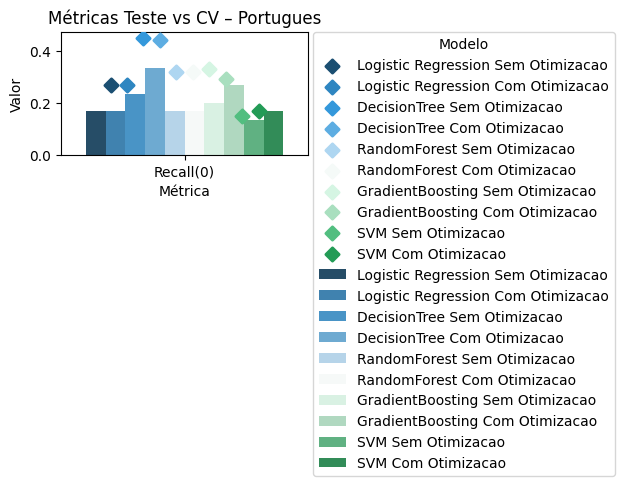


--- Comparando Resultados para a Métrica: F1 Score (Reprovado) ---


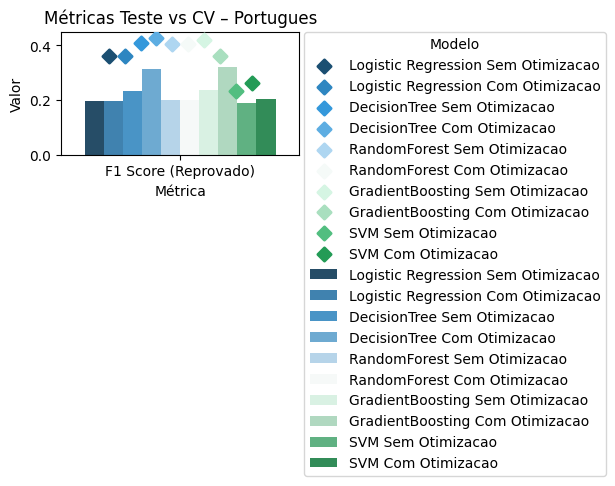


--- Comparando Resultados para a Métrica: F1 Score (Macro) ---


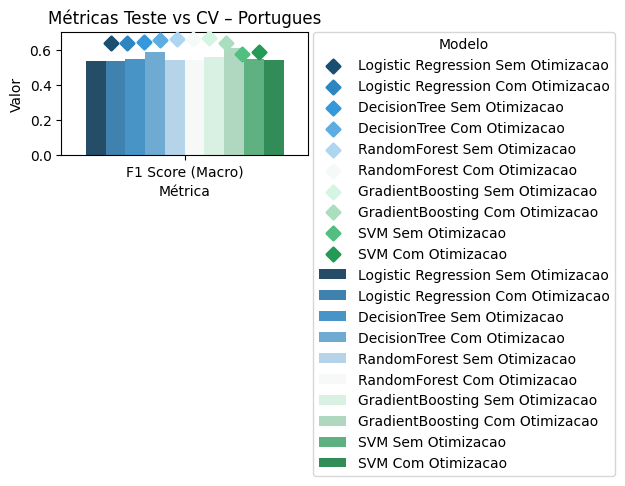


--- Comparando Resultados para a Métrica: AUC ROC ---


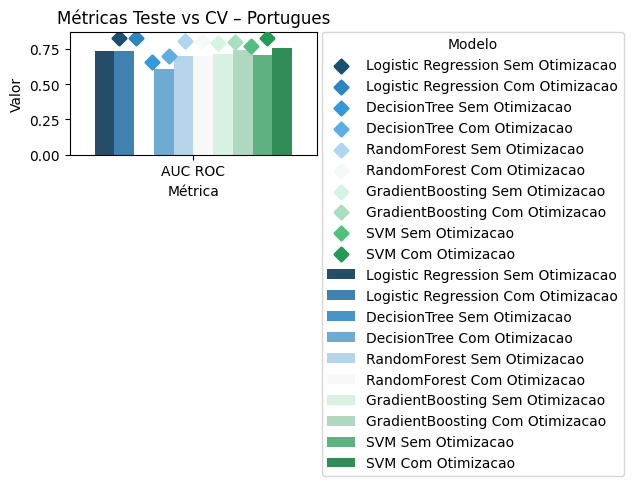

In [17]:
display(df_resultados)

display(df_cv)

display(verificar_overfitting(df_resultados_bal, df_cv))

metricas_interesse = ['Recall(0)', 'F1 Score (Reprovado)', 'F1 Score (Macro)', 'AUC ROC']


for metric in metricas_interesse:
    if metric:
        print(f"\n--- Comparando Resultados para a Métrica: {metric} ---")
        comparar_resultados_classificacao(
                                            df_test=df_resultados, 
                                            df_cv=df_cv,           
                                            metrics=metric,        
                                            materia=materia  
                                         )     

,Modelo,Acurácia,Precisão(0),Precisão(1),Recall(0),Recall(1),F1 Score (Reprovado),F1 Score (Macro),AUC ROC
0,Logistic Regression Sem Otimizacao,0.712821,0.296875,0.916031,0.633333,0.727273,0.404255,0.607533,0.744646
1,Logistic Regression Com Otimizacao,0.743590,0.327586,0.919708,0.633333,0.763636,0.431818,0.633128,0.733737
2,DecisionTree Sem Otimizacao,0.769231,0.297297,0.879747,0.366667,0.842424,0.328358,0.594520,NaN
3,DecisionTree Com Otimizacao,0.784615,0.357143,0.901961,0.500000,0.836364,0.416667,0.642296,0.637475
4,RandomForest Sem Otimizacao,0.774359,0.266667,0.866667,0.266667,0.866667,0.266667,0.566667,0.699495
5,RandomForest Com Otimizacao,0.774359,0.266667,0.866667,0.266667,0.866667,0.266667,0.566667,0.699495
6,GradientBoosting Sem Otimizacao,0.789744,0.280000,0.864706,0.233333,0.890909,0.254545,0.566079,0.698586
7,GradientBoosting Com Otimizacao,0.784615,0.250000,0.859649,0.200000,0.890909,0.222222,0.548611,0.617172
8,SVM Sem Otimizacao,0.758974,0.302326,0.888158,0.433333,0.818182,0.356164,0.603950,0.704848
9,SVM Com Otimizacao,0.764103,0.264706,0.869565,0.300000,0.848485,0.281250,0.570073,0.634343


,Modelo,Validação Cruzada (AUC ROC),Validação Cruzada (Acurácia),Validação Cruzada (Precisão(0)),Validação Cruzada (Precisão(1)),Validação Cruzada (Recall(0)),Validação Cruzada (Recall(1)),Validação Cruzada (F1 Score (Reprovado)),Validação Cruzada (F1 Score (Macro))
0,Logistic Regression Sem Otimizacao,0.829,0.857,0.586,0.879,0.27,0.964,0.362,0.641
1,Logistic Regression Com Otimizacao,0.836,0.852,0.537,0.873,0.23,0.965,0.319,0.618
2,DecisionTree Sem Otimizacao,0.657,0.800,0.381,0.896,0.45,0.863,0.409,0.644
3,DecisionTree Com Otimizacao,0.692,0.849,0.558,0.883,0.31,0.947,0.383,0.648
4,RandomForest Sem Otimizacao,0.805,0.861,0.623,0.886,0.32,0.960,0.406,0.664
5,RandomForest Com Otimizacao,0.805,0.861,0.623,0.886,0.32,0.960,0.406,0.664
6,GradientBoosting Sem Otimizacao,0.789,0.860,0.606,0.887,0.33,0.956,0.419,0.669
7,GradientBoosting Com Otimizacao,0.726,0.831,0.443,0.886,0.35,0.918,0.385,0.643
8,SVM Sem Otimizacao,0.769,0.851,0.528,0.863,0.15,0.978,0.231,0.574
9,SVM Com Otimizacao,0.748,0.857,0.553,0.891,0.36,0.947,0.429,0.674


,Modelo,Δ Acurácia,Δ Precisão(1),Δ Precisão(0),Δ Recall(1),Δ Recall(0),Δ F1 Score (Reprovado),Δ F1 Score (Macro),Δ AUC ROC,Média Δ (%),Diagnóstico
0,Logistic Regression Sem Otimizacao,16.8%,-4.2%,49.3%,24.6%,-134.6%,-11.7%,5.2%,10.2%,-5.5%,OK
1,Logistic Regression Com Otimizacao,12.7%,-5.4%,39.0%,20.9%,-175.4%,-35.4%,-2.4%,12.2%,-16.7%,OK
2,DecisionTree Sem Otimizacao,3.8%,1.8%,22.0%,2.4%,18.5%,19.7%,7.7%,nan%,nan%,OK
3,DecisionTree Com Otimizacao,7.6%,-2.1%,36.0%,11.7%,-61.3%,-8.8%,0.9%,7.9%,-1.0%,OK
4,RandomForest Sem Otimizacao,10.1%,2.2%,57.2%,9.7%,16.7%,34.3%,14.7%,13.1%,19.7%,Overfitting
5,RandomForest Com Otimizacao,10.1%,2.2%,57.2%,9.7%,16.7%,34.3%,14.7%,13.1%,19.7%,Overfitting
6,GradientBoosting Sem Otimizacao,8.2%,2.5%,53.8%,6.8%,29.3%,39.2%,15.4%,11.5%,20.8%,Overfitting
7,GradientBoosting Com Otimizacao,5.6%,3.0%,43.6%,3.0%,42.9%,42.3%,14.7%,15.0%,21.2%,Overfitting
8,SVM Sem Otimizacao,10.8%,-2.9%,42.7%,16.3%,-188.9%,-54.2%,-5.2%,8.3%,-21.6%,OK
9,SVM Com Otimizacao,10.8%,2.4%,52.1%,10.4%,16.7%,34.4%,15.4%,15.2%,19.7%,Overfitting



--- Comparando Resultados para a Métrica: Recall(0) ---


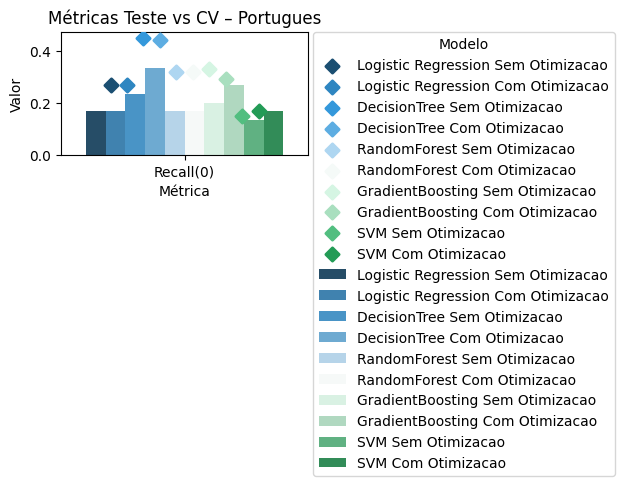


--- Comparando Resultados para a Métrica: F1 Score (Reprovado) ---


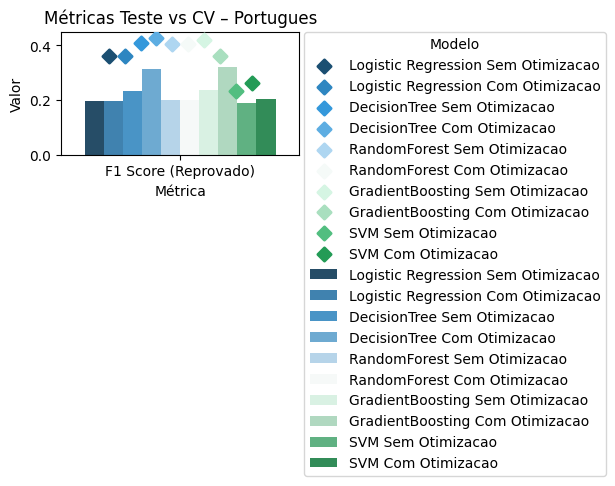


--- Comparando Resultados para a Métrica: F1 Score (Macro) ---


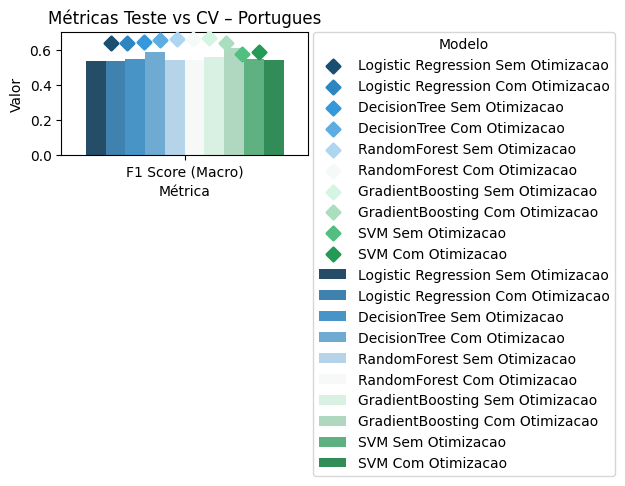


--- Comparando Resultados para a Métrica: AUC ROC ---


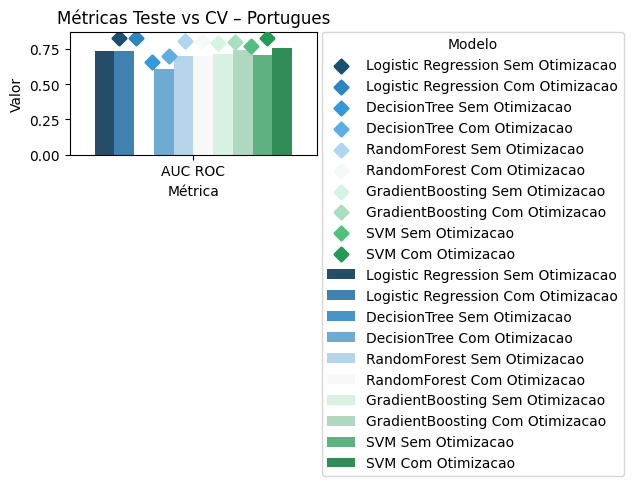

In [18]:
display(df_resultados_bal)

display(df_cv_bal)

display(verificar_overfitting(df_resultados_bal, df_cv_bal))


metricas_interesse = ['Recall(0)', 'F1 Score (Reprovado)', 'F1 Score (Macro)', 'AUC ROC']


for metric in metricas_interesse:
    if metric:
        print(f"\n--- Comparando Resultados para a Métrica: {metric} ---")
        comparar_resultados_classificacao(
                                            df_test=df_resultados, 
                                            df_cv=df_cv,           
                                            metrics=metric,        
                                            materia=materia  
                                         )     

# 5. Modelagem 2: Seleção Baseada em Impacto Observado na EDA e Relevância Contextual



In [19]:
selecao_descarte = [
    'tamanho_familia',
    'status_parental_Separados',
    'responsavel_legal_Pai',
    'tempo_transporte',
    'apoio_escolar',
    'apoio_familiar',
    'aulas_particulares',
    'atividades_extracurriculares',
    'frequentou_creche',
    'relacionamento_romantico',
    'relacao_familiar',
    'tempo_livre'
]


In [20]:
X = df_fs.drop(columns=selecao_descarte)
y = df_fs['aprovacao']

In [21]:
# === Avaliação SEM balanceamento ===
df_resultados, df_cv, best_params_df = avaliar_classificadores_binarios_otimizados(
    classificadores=classificadores,
    X=X,
    y=y,
    materia="portugues",  # ou "matematica"
    usar_balanceamento=False,
    param_spaces=param_grid_dicts
)

# === Avaliação COM balanceamento ===
df_resultados_bal, df_cv_bal, best_params_df_bal = avaliar_classificadores_binarios_otimizados(
    classificadores=classificadores,
    X=X,
    y=y,
    materia="portugues",  # ou "matematica"
    usar_balanceamento=True,
    param_spaces= param_grid_dicts
)

,Modelo,Acurácia,Precisão(0),Precisão(1),Recall(0),Recall(1),F1 Score (Reprovado),F1 Score (Macro),AUC ROC
0,Logistic Regression Sem Otimizacao,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Logistic Regression Com Otimizacao,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,DecisionTree Sem Otimizacao,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN
3,DecisionTree Com Otimizacao,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN
4,RandomForest Sem Otimizacao,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,RandomForest Com Otimizacao,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,GradientBoosting Sem Otimizacao,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,GradientBoosting Com Otimizacao,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,SVM Sem Otimizacao,0.984615,0.965517,0.987952,0.933333,0.993939,0.949153,0.970045,0.997374
9,SVM Com Otimizacao,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,Modelo,Validação Cruzada (AUC ROC),Validação Cruzada (Acurácia),Validação Cruzada (Precisão(0)),Validação Cruzada (Precisão(1)),Validação Cruzada (Recall(0)),Validação Cruzada (Recall(1)),Validação Cruzada (F1 Score (Reprovado)),Validação Cruzada (F1 Score (Macro))
0,Logistic Regression Sem Otimizacao,1.000,1.000,1.00,1.000,1.00,1.000,1.000,1.000
1,Logistic Regression Com Otimizacao,1.000,1.000,1.00,1.000,1.00,1.000,1.000,1.000
2,DecisionTree Sem Otimizacao,1.000,1.000,1.00,1.000,1.00,1.000,1.000,1.000
3,DecisionTree Com Otimizacao,1.000,1.000,1.00,1.000,1.00,1.000,1.000,1.000
4,RandomForest Sem Otimizacao,1.000,1.000,1.00,1.000,1.00,1.000,1.000,1.000
5,RandomForest Com Otimizacao,1.000,1.000,1.00,1.000,1.00,1.000,1.000,1.000
6,GradientBoosting Sem Otimizacao,1.000,1.000,1.00,1.000,1.00,1.000,1.000,1.000
7,GradientBoosting Com Otimizacao,1.000,1.000,1.00,1.000,1.00,1.000,1.000,1.000
8,SVM Sem Otimizacao,0.999,0.985,0.98,0.986,0.92,0.996,0.948,0.969
9,SVM Com Otimizacao,1.000,1.000,1.00,1.000,1.00,1.000,1.000,1.000



--- Comparando Resultados para a Métrica: Recall(0) ---


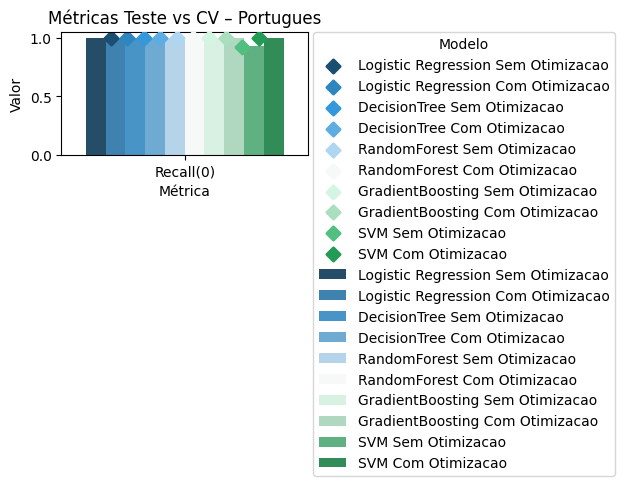


--- Comparando Resultados para a Métrica: F1 Score (Reprovado) ---


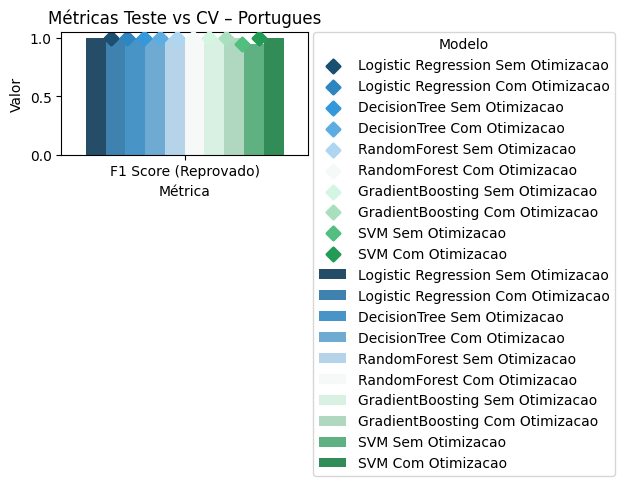


--- Comparando Resultados para a Métrica: F1 Score (Macro) ---


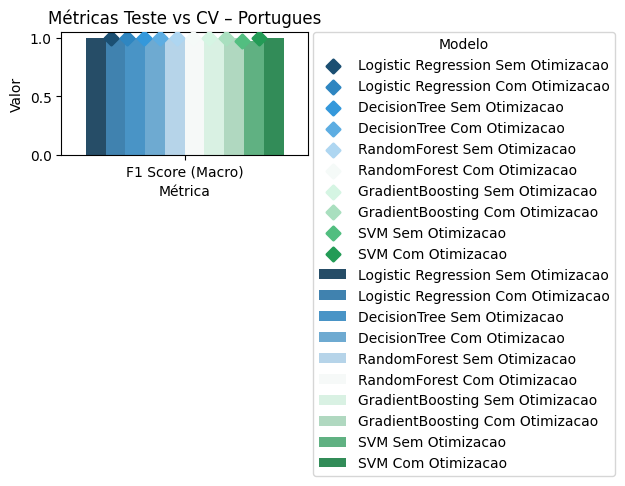


--- Comparando Resultados para a Métrica: AUC ROC ---


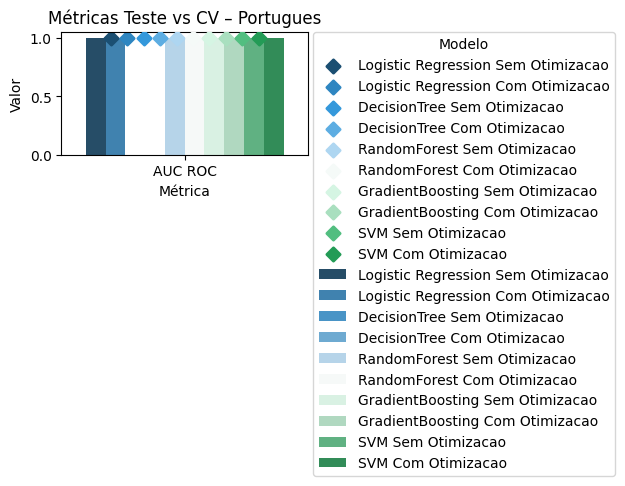

In [22]:
display(df_resultados)

display(df_cv)

verificar_overfitting(df_resultados_bal, df_cv)

metricas_interesse = ['Recall(0)', 'F1 Score (Reprovado)', 'F1 Score (Macro)', 'AUC ROC']


for metric in metricas_interesse:
    if metric:
        print(f"\n--- Comparando Resultados para a Métrica: {metric} ---")
        comparar_resultados_classificacao(
                                            df_test=df_resultados, 
                                            df_cv=df_cv,           
                                            metrics=metric,        
                                            materia=materia  
                                         )     

,Modelo,Acurácia,Precisão(0),Precisão(1),Recall(0),Recall(1),F1 Score (Reprovado),F1 Score (Macro),AUC ROC
0,Logistic Regression Sem Otimizacao,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000
1,Logistic Regression Com Otimizacao,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000
2,DecisionTree Sem Otimizacao,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,NaN
3,DecisionTree Com Otimizacao,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,NaN
4,RandomForest Sem Otimizacao,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000
5,RandomForest Com Otimizacao,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000
6,GradientBoosting Sem Otimizacao,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000
7,GradientBoosting Com Otimizacao,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000
8,SVM Sem Otimizacao,0.994872,0.967742,1.0,1.0,0.993939,0.983607,0.990284,0.999394
9,SVM Com Otimizacao,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000


,Modelo,Validação Cruzada (AUC ROC),Validação Cruzada (Acurácia),Validação Cruzada (Precisão(0)),Validação Cruzada (Precisão(1)),Validação Cruzada (Recall(0)),Validação Cruzada (Recall(1)),Validação Cruzada (F1 Score (Reprovado)),Validação Cruzada (F1 Score (Macro))
0,Logistic Regression Sem Otimizacao,1.000,1.000,1.00,1.000,1.00,1.000,1.000,1.000
1,Logistic Regression Com Otimizacao,1.000,1.000,1.00,1.000,1.00,1.000,1.000,1.000
2,DecisionTree Sem Otimizacao,1.000,1.000,1.00,1.000,1.00,1.000,1.000,1.000
3,DecisionTree Com Otimizacao,1.000,1.000,1.00,1.000,1.00,1.000,1.000,1.000
4,RandomForest Sem Otimizacao,1.000,1.000,1.00,1.000,1.00,1.000,1.000,1.000
5,RandomForest Com Otimizacao,1.000,1.000,1.00,1.000,1.00,1.000,1.000,1.000
6,GradientBoosting Sem Otimizacao,1.000,1.000,1.00,1.000,1.00,1.000,1.000,1.000
7,GradientBoosting Com Otimizacao,1.000,0.846,0.00,0.846,0.00,1.000,0.000,0.458
8,SVM Sem Otimizacao,0.999,0.985,0.98,0.986,0.92,0.996,0.948,0.969
9,SVM Com Otimizacao,1.000,1.000,1.00,1.000,1.00,1.000,1.000,1.000



--- Comparando Resultados para a Métrica: Recall(0) ---


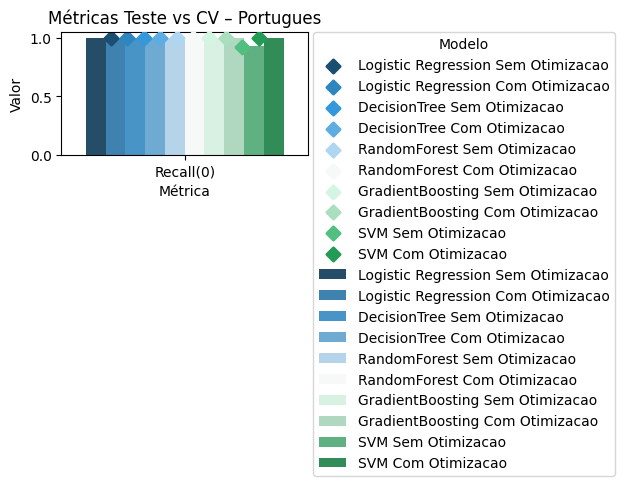


--- Comparando Resultados para a Métrica: F1 Score (Reprovado) ---


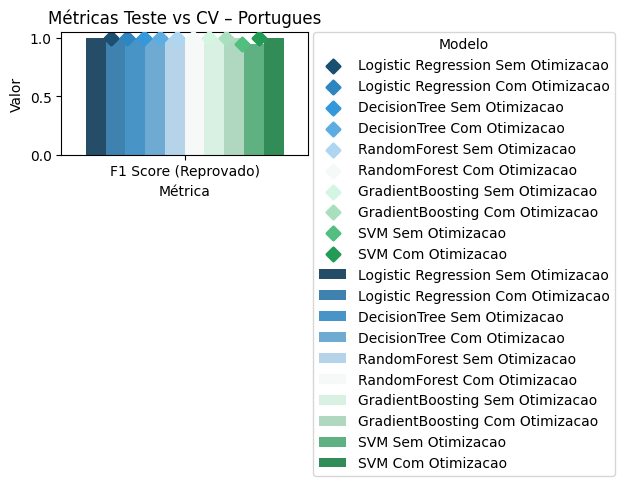


--- Comparando Resultados para a Métrica: F1 Score (Macro) ---


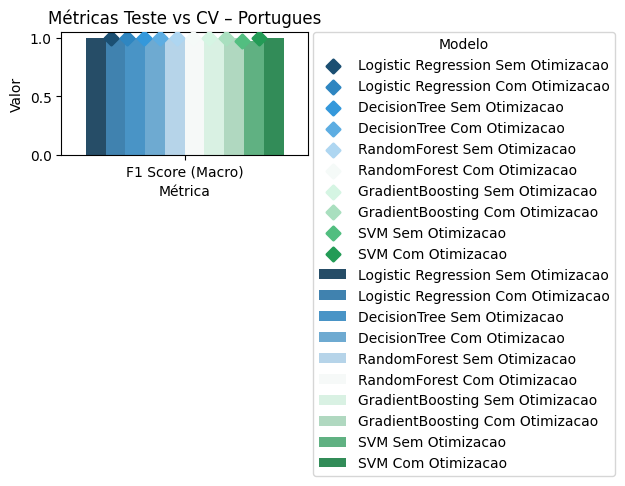


--- Comparando Resultados para a Métrica: AUC ROC ---


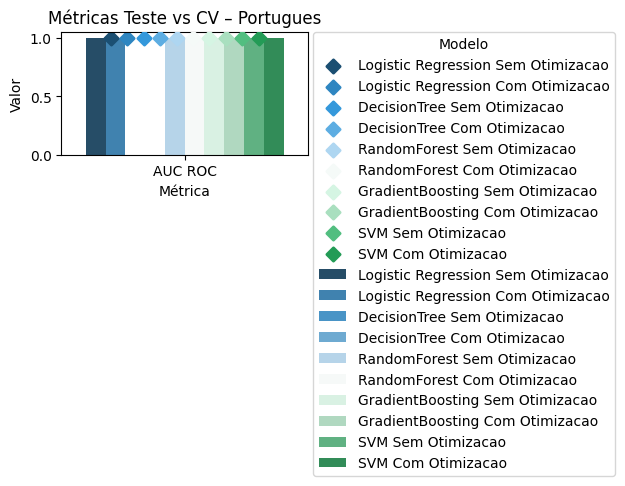

In [23]:
display(df_resultados_bal)

display(df_cv_bal)

verificar_overfitting(df_resultados_bal, df_cv_bal)


metricas_interesse = ['Recall(0)', 'F1 Score (Reprovado)', 'F1 Score (Macro)', 'AUC ROC']


for metric in metricas_interesse:
    if metric:
        print(f"\n--- Comparando Resultados para a Métrica: {metric} ---")
        comparar_resultados_classificacao(
                                            df_test=df_resultados, 
                                            df_cv=df_cv,           
                                            metrics=metric,        
                                            materia=materia  
                                         )     